In [1]:
import re
import nltk
from sklearn import svm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from google_trans_new import google_translator  
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
import matplotlib.pyplot as plt
import typing
import numpy as np
import pandas as pd

In [2]:
fg_df = pd.read_csv('D:/Users/ehern/Desktop/Machine Learning/Project/fall_guys_metacritic_reviews.csv')

fg_df.head()

,username,review_type,published_date,score,votes,review_text,profile_url,platform
0,Fen1ma,user,"Aug 26, 2020",6.0,0.0,"на данный момент не советую покупать игру, ещё...",https://www.metacritic.com/user/Fen1ma,pc
1,Locke_VI,user,"Aug 25, 2020",3.0,0.0,Fall Guys was a game I was really looking forw...,https://www.metacritic.com/user/Locke_VI,pc
2,Crisener,user,"Aug 25, 2020",8.0,0.0,You gotta love it. The aesthetics are very col...,https://www.metacritic.com/user/Crisener,pc
3,EnigmaXtreme,user,"Aug 25, 2020",7.0,0.0,When we covered Fall Guys last week during it’...,https://www.metacritic.com/user/EnigmaXtreme,pc
4,nitorita,user,"Aug 23, 2020",7.0,0.0,I like how Fall Guys adapted Mario Party and m...,https://www.metacritic.com/user/nitorita,pc


In [3]:
fg_df.drop(columns=['username','review_type','published_date','published_date', 'votes', 'profile_url', 'platform'],inplace=True)

In [4]:
noNull = fg_df.dropna()

In [5]:
# for i in noNull['review_text']:
#     detector = google_translator()  
#     detect_result = detector.detect(i)
#     print(detect_result)

In [6]:
translations = {}
for i in noNull['review_text']:
    translator = google_translator()
    translations[i] = translator.translate(i, lang_tgt='en')
    
noNull.replace(translations, inplace = True)

# check translation
noNull

C:\Users\ehern\anaconda3\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,score,review_text
0,6.0,At the moment I do not advise you to buy the g...
1,3.0,Fall Guys was a game I was really looking forw...
2,8.0,You gotta love it. The aesthetics are very col...
3,7.0,When we covered Fall Guys last week during it’...
4,7.0,I like how Fall Guys adapted Mario Party and m...
...,...,...
349,1.0,Fall guys is a great game that is destroyed by...
350,9.0,"Simple and fun, very easy to understand gamepl..."
351,8.0,"HIVALLY FOR ALL ages, and when you only have a..."
352,9.0,This game is fun but when you play with friend...


In [74]:
translated_df = noNull.copy()

In [75]:
translated_df.isnull().sum()

score          0
review_text    0
dtype: int64

In [76]:
translated_df.describe()

,score
count,329.000000
mean,6.802432
std,3.340512
min,0.000000
25%,5.000000
50%,8.000000
75%,10.000000
max,10.000000


In [77]:
translated_df['score'].value_counts()

10.0    83
8.0     61
9.0     50
0.0     34
7.0     26
6.0     20
5.0     15
2.0     12
1.0     11
3.0     10
4.0      7
Name: score, dtype: int64

In [78]:
def remove_links(text):
    # Remove any hyperlinks that may be in the text starting with http
    import re
    return re.sub(r"http\S+", "", text)

def remove_apostrophes(text):
    text = text.replace("'", "")
    text = text.replace('"', "")
    text = text.replace('`', "")
    return text

In [79]:
translated_df['review_text'] = translated_df['review_text'].str.lower()

In [80]:
translated_df['review_text'] = translated_df['review_text'].str.replace('[^\w\s]','')

In [81]:
translated_df['review_text'] = translated_df['review_text'].astype(str).apply(remove_links)

In [82]:
translated_df['review_text'] = translated_df['review_text'].apply(remove_apostrophes)

In [83]:
translated_df.head()

,score,review_text
0,6.0,at the moment i do not advise you to buy the g...
1,3.0,fall guys was a game i was really looking forw...
2,8.0,you gotta love it the aesthetics are very colo...
3,7.0,when we covered fall guys last week during its...
4,7.0,i like how fall guys adapted mario party and m...


In [84]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer

In [85]:
def tokenize(text):
    tokens = re.split('\W+', str(text))
    return tokens

translated_df['review_text'] = translated_df['review_text'].apply(lambda w: tokenize(w))
translated_df.head()

,score,review_text
0,6.0,"[at, the, moment, i, do, not, advise, you, to,..."
1,3.0,"[fall, guys, was, a, game, i, was, really, loo..."
2,8.0,"[you, gotta, love, it, the, aesthetics, are, v..."
3,7.0,"[when, we, covered, fall, guys, last, week, du..."
4,7.0,"[i, like, how, fall, guys, adapted, mario, par..."


In [86]:
stopwords = nltk.corpus.stopwords.words('english')
def removeStopWords(text):
    cleanText = [w for w in text if w not in stopwords]
    return cleanText

translated_df['review_text'] = translated_df['review_text'].apply(lambda w: removeStopWords(w))
translated_df.head()

,score,review_text
0,6.0,"[moment, advise, buy, game, still, raw, br, mi..."
1,3.0,"[fall, guys, game, really, looking, forward, f..."
2,8.0,"[gotta, love, aesthetics, colorful, charming, ..."
3,7.0,"[covered, fall, guys, last, week, beta, talked..."
4,7.0,"[like, fall, guys, adapted, mario, party, made..."


In [87]:
def listToString(text): 
    str1 = " " 
    return (str1.join(text))
        
translated_df['review_text'] = translated_df['review_text'].apply(lambda w: listToString(w))
translated_df.head()

,score,review_text
0,6.0,moment advise buy game still raw br minuses br...
1,3.0,fall guys game really looking forward first an...
2,8.0,gotta love aesthetics colorful charming gamepl...
3,7.0,covered fall guys last week beta talked fun ga...
4,7.0,like fall guys adapted mario party made suppor...


In [88]:
translated_df['review_text'][0]

'moment advise buy game still raw br minuses br absence antichit br cannot change nickname br cursor game hidden 2 times clicking es 1 round br little content br going main menu game may freeze progress game saved br controversial cons support 21 9 maximum permission full hd reduce brightness colors br pros br fun play friends br large selection cart customization br br outcome br worth buying already bought friends cases buy play start adding content '

In [89]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_analyzer = SentimentIntensityAnalyzer()

In [90]:
def get_sentiment(text:str, analyser,desired_type:str='pos'):
    # Get sentiment from text
    sentiment_score = analyser.polarity_scores(text)
    return sentiment_score[desired_type]

# Get Sentiment scores
def get_sentiment_scores(df,data_column):
    df['positive sentiment score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sid_analyzer,'pos')*10)
    df['negative sentiment score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sid_analyzer,'neg')*10)
    df['neutral sentiment score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sid_analyzer,'neu')*10)
    df['compound sentiment score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sid_analyzer,'compound')*10)
    return df

In [91]:
text_sentiment = get_sentiment_scores(translated_df, 'review_text')

display(text_sentiment.sample(5))

,score,review_text,positive sentiment score,negative sentiment score,neutral sentiment score,compound sentiment score
280,0.0,rating game 0 5 wins row throphy want easier a...,2.35,1.23,6.42,7.269
225,9.0,fun game fire friends basically play takeshis ...,3.45,1.28,5.27,9.829
7,8.0,servers largely fixed finding groove see game ...,0.90,1.79,7.31,-7.077
323,6.0,really like game many server problems disconne...,1.45,2.75,5.80,-5.584
134,0.0,poor games week game people tryharding thx rui...,1.84,3.75,4.41,-3.818


In [92]:
def print_top_n_reviews(df,data_column,number_of_rows):
    for index,row in df.nlargest(number_of_rows,data_column).iterrows():
        print(f"Predicted Score: {row[data_column]}")
        print(f"Review: {row[1]}")
        print(f"Actual Score: {row[0]}\n")

In [93]:
print_top_n_reviews(text_sentiment,'positive sentiment score',2)

Predicted Score: 9.48
Review: super fun game entertaining competitive fun friends 
Actual Score: 10.0

Predicted Score: 8.08
Review: fun yellow humor great game fast games laugh perfect 
Actual Score: 10.0



In [94]:
print_top_n_reviews(text_sentiment,'negative sentiment score',2)

Predicted Score: 6.3
Review: stupid football dsuhsuhwhjwhhbhsbhhsbhhdhbhdbhbdhbhdbdbhhbhbshhsubhusbhbshubhus 
Actual Score: 1.0

Predicted Score: 5.9399999999999995
Review: boring controls bad music sucks visuals colorful hurt eyes stay away isnt 
Actual Score: 3.0



In [95]:
print_top_n_reviews(text_sentiment,'neutral sentiment score',2)

Predicted Score: 10.0
Review: hi playstation russia normal games 
Actual Score: 0.0

Predicted Score: 10.0
Review: sort servers game pointless let finish episode 
Actual Score: 1.0



In [96]:
print_top_n_reviews(text_sentiment,'compound sentiment score',2)

Predicted Score: 9.99
Review: firstly terms visuals game goes heavily stylized cartoony aesthetic really works every obstacle course arena bright colorful fun look everyone controls strange looking round fella customize different colors silly looking accessories gives incentive keep leveling earning coins unlock items emotes also adds goofy cartoony feel game mean good way animations guys emotes normal animations play rounds also go long way add fun charm simple designs guys also love silly cartoony sound effects happen fall bump someone fall guys prettiest thing works personally really like br bras plays game referred episode treating like really ninja warrior style tv show episodes broken several rounds players steadily eliminated one player left standing rounds range obstacle course style reach end sourt affairs probably favorite really feels like test platforming skills slightly annoying parts levels like see saw risk stuck seesaw people dont know balance weight distribution work s

In [97]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def collapse_list_to_string(string_list):
    return ' '.join(string_list)

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

translated_df['review_text'] = translated_df['review_text'].astype(str).apply(lemmatize_text)

translated_df['review_text'] = translated_df['review_text'].apply(collapse_list_to_string)

display(translated_df['review_text'])

0      moment advise buy game still raw br minus br a...
1      fall guy game really looking forward first ann...
2      gotta love aesthetic colorful charming gamepla...
3      covered fall guy last week beta talked fun gam...
4      like fall guy adapted mario party made support...
                             ...                        
349    fall guy great game destroyed couple problem m...
350    simple fun easy understand gameplay better yet...
351                       hivally age nothing difficulty
352    game fun play friend becomes really fun honest...
353    awesome lot fun laugh im worried enough stage ...
Name: review_text, Length: 329, dtype: object

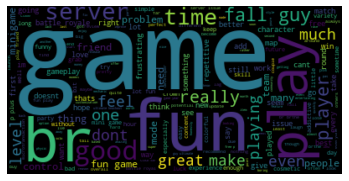

In [98]:
def plot_wordcloud(series,output_filename='wordcloud'):
    wordcloud = WordCloud().generate(' '.join(series.astype(str)))
    wordcloud.to_file(output_filename + '.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

plot_wordcloud(translated_df['review_text'],'overall-wordcloud')

def plot_wordcloud_top_n(df,number_of_reviews,score_column,data_column,output_filename):
    sliced_df = df.nlargest(number_of_reviews,score_column)
    plot_wordcloud(sliced_df[data_column],output_filename)

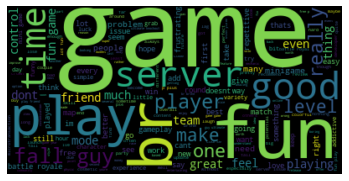

In [99]:
plot_wordcloud_top_n(translated_df,500,'positive sentiment score','review_text','positive-wordcloud')

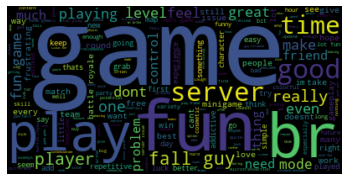

In [100]:
plot_wordcloud_top_n(translated_df,500,'negative sentiment score','review_text','negative-wordcloud')

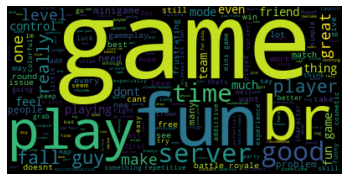

In [101]:
plot_wordcloud_top_n(translated_df,500,'neutral sentiment score', 'review_text', 'neutral-wordcloud')

In [102]:
# X = np.array(new_model.wv['bad'], dtype=float).reshape(-1, 1)
features = ['positive sentiment score', 'negative sentiment score', 'neutral sentiment score']
X = translated_df[features].astype(int)
y = translated_df['score']
# y = translated_df['score']

In [103]:
X

,positive sentiment score,negative sentiment score,neutral sentiment score
0,2,0,6
1,1,1,6
2,3,0,6
3,2,0,6
4,2,0,6
...,...,...,...
349,1,2,5
350,6,0,3
351,4,0,5
352,5,0,4


In [104]:
y

0      6.0
1      3.0
2      8.0
3      7.0
4      7.0
      ... 
349    1.0
350    9.0
351    8.0
352    9.0
353    9.0
Name: score, Length: 329, dtype: float64

In [105]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print(classification_report(y_test, y_predict, zero_division=1))
    return accuracy

In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

print("Accuracy:", get_score(DecisionTreeClassifier(), X_train, X_test, y_train, y_test))

cv_score_dt = cross_val_score(DecisionTreeClassifier(), X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_dt.mean()))

              precision    recall  f1-score   support

         0.0       0.20      0.22      0.21         9
         1.0       0.00      0.00      0.00         4
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         4
         4.0       1.00      0.00      0.00         5
         5.0       0.00      0.00      0.00         2
         6.0       0.00      0.00      0.00         4
         7.0       0.17      0.40      0.24         5
         8.0       0.18      0.35      0.24        17
         9.0       0.00      0.00      0.00        16
        10.0       0.68      0.48      0.57        31

    accuracy                           0.25        99
   macro avg       0.20      0.13      0.11        99
weighted avg       0.32      0.25      0.25        99

Accuracy: 0.25252525252525254

Cross Validation Accuracy: 0.20671328671328668


In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25)

print("Accuracy:", get_score(LogisticRegression(max_iter=1000), X_train, X_test, y_train, y_test))

cv_score_lr = cross_val_score(LogisticRegression(max_iter=1000), X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_lr.mean()))

              precision    recall  f1-score   support

         0.0       0.40      0.75      0.52         8
         1.0       1.00      0.00      0.00         2
         2.0       1.00      0.00      0.00         1
         3.0       1.00      0.00      0.00         1
         4.0       1.00      0.00      0.00         2
         5.0       1.00      0.00      0.00         6
         6.0       1.00      0.00      0.00         6
         7.0       1.00      0.00      0.00         7
         8.0       0.24      0.54      0.33        13
         9.0       1.00      0.00      0.00        11
        10.0       0.54      0.81      0.65        26

    accuracy                           0.41        83
   macro avg       0.83      0.19      0.14        83
weighted avg       0.68      0.41      0.30        83

Accuracy: 0.40963855421686746

Cross Validation Accuracy: 0.318974358974359


In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

print("Accuracy:", get_score(RandomForestClassifier(), X_train, X_test, y_train, y_test))

cv_score_rf = cross_val_score(RandomForestClassifier(), X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_rf.mean()))

              precision    recall  f1-score   support

         0.0       0.30      0.33      0.32         9
         1.0       0.00      0.00      0.00         1
         2.0       1.00      0.00      0.00         4
         3.0       1.00      0.00      0.00         4
         4.0       1.00      0.00      0.00         2
         5.0       1.00      0.00      0.00         4
         6.0       0.00      0.00      0.00         4
         7.0       0.15      0.50      0.24         4
         8.0       0.18      0.15      0.16        20
         9.0       0.00      0.00      0.00        10
        10.0       0.39      0.62      0.48        21

    accuracy                           0.25        83
   macro avg       0.46      0.15      0.11        83
weighted avg       0.35      0.25      0.21        83

Accuracy: 0.25301204819277107

Cross Validation Accuracy: 0.19757575757575757


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25)

print("Accuracy:", get_score(svm.SVC(), X_train, X_test, y_train, y_test))

cv_score_svm = cross_val_score(svm.SVC(), X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_svm.mean()))

              precision    recall  f1-score   support

         0.0       0.33      0.62      0.43         8
         1.0       1.00      0.00      0.00         2
         2.0       1.00      0.00      0.00         1
         3.0       1.00      0.00      0.00         1
         4.0       1.00      0.00      0.00         2
         5.0       1.00      0.00      0.00         6
         6.0       1.00      0.00      0.00         6
         7.0       1.00      0.00      0.00         7
         8.0       0.28      0.69      0.40        13
         9.0       1.00      0.00      0.00        11
        10.0       0.56      0.77      0.65        26

    accuracy                           0.41        83
   macro avg       0.83      0.19      0.13        83
weighted avg       0.68      0.41      0.31        83

Accuracy: 0.40963855421686746

Cross Validation Accuracy: 0.3007925407925408


In [110]:
input_size = 784
hidden_neurons = 100
out_size = 10

In [111]:
## Designing the ANN Structure (with 784 inputs, 10 outputs and 100 neuron in a hidden layer):
def model_creator():
# -----------------------------------------
# first layer: input layer
# Input layer does not do any processing, so no need to define the input layer in this problem.
    model = Sequential()
    # -----------------------------------------
    # second layer: hidden layer:
    model.add(Dense(hidden_neurons, input_dim = input_size))  # Nuerons
    model.add(Activation('sigmoid')) # Activation

    # -----------------------------------------
    # third layer: output layer:
    model.add(Dense(out_size, input_dim = hidden_neurons))  # Nuerons
    model.add(Activation('softmax')) # Activation

    model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
    
    return model

In [112]:
np.random.seed(2)

In [113]:
model = KerasClassifier(build_fn = model_creator, verbose=2)

In [116]:
param_grid = dict(batch_size = [30], epochs = [15])

grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'neg_log_loss', cv = 5)

grid_result = grid.fit(X_train, y_train)

Epoch 1/15
Epoch 1/15
Epoch 1/15


C:\Users\ehern\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ehern\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\eager

Epoch 1/15
Epoch 1/15
Epoch 1/15


C:\Users\ehern\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ehern\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\eager

ValueError: in user code:

    C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\ehern\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_143 is incompatible with the layer: expected axis -1 of input shape to have value 784 but received input with shape (None, 3)


In [ ]:
print(grid.best_params_)